In [1]:
from datasets import load_dataset

ds = load_dataset("TIGER-Lab/MMLU-Pro")

ds

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 12032
    })
    validation: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 70
    })
})

In [2]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "google/madlad400-10b-mt"
model = T5ForConditionalGeneration.from_pretrained(
    model_name, device_map="cuda:3", torch_dtype=torch.bfloat16
)
tokenizer = T5Tokenizer.from_pretrained(model_name)
# Eu adoro pizza!

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [2]:
import pandas as pd

# [11584:]
df = ds['test'].to_pandas()

# df = ds['test'].to_pandas()
# df['question_ru'] = None

df.to_csv('mmlu_pro_test.csv')

In [4]:
df.head()

question_id                                           question  \
0           70  Typical advertising regulatory bodies suggest,...   
1           71  Managers are entrusted to run the company in t...   
2           72  There are two main issues associated with ____...   
3           73  _______ locate morality beyond the sphere of r...   
4           74   Some of key differences between Islamic finan...   

                                             options answer  answer_index  \
0  [Safe practices, Fear, Jealousy, Trivial, Unsa...      I             8   
1  [Shareholders, Diligence, Self-interest, Share...      F             5   
2  [Down, Autonomy, Remuneration, Benefit, Down, ...      J             9   
3  [Ethical egoism, Ethics of duty, Postmodern et...      C             2   
4  [Interest, Certain, Assured, Both tangible and...      G             6   

  cot_content  category                       src question_ru  
0              business  ori_mmlu-business_ethics        None  
1              business  ori_mmlu-business_ethics        None  
2              business  ori_mmlu-business_ethics        None  
3              business  ori_mmlu-business_ethics        None  
4              business  ori_mmlu-business_ethics        None

In [6]:
ins = tokenizer(ds["test"]["question"], padding=True)

# Find the max length in tokens
max_length = max([len(tokens) for tokens in ins['input_ids']])

# Print the result
print("Max length in tokens:", max_length)

Max length in tokens: 1558


In [7]:
from tqdm import tqdm
from torch.utils.data import DataLoader


def collate_fn(batch):
    # Tokenize the questions in the batch
    inputs = tokenizer(
        ["<2ru> " + text["question"] for text in batch],
        return_tensors="pt",
        padding=True,  # Enable padding
    ).input_ids.to(model.device)
    return inputs


test_dataset = ds["test"]
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

In [ ]:
questions_ru = []

# Now you can iterate over the test_dataloader in batches
for batch in tqdm(test_dataloader):
    # Access the features in each batch
    questions = batch  # Assuming 'question' contains the English questions

    # Apply your translation logic here
    output_sequences = model.generate(input_ids=batch, max_new_tokens=2048)

    answers = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

    # Now you have the translated questions in questions_ru
    # You can process them further as needed
    # print(batch)
    # print("-------")
    print(answers)
    # print("\n\n")
    questions_ru.append(answers)

In [12]:
questions_ru

[['Типичные органы по регулированию рекламы предлагают, например, чтобы реклама не поощряла _________, не вызывала ненужного ________ или _________ и не вызывала _______ оскорбления.',
  'Руководителям поручено управлять компанией в наилучших интересах ________. В частности, они обязаны действовать в интересах компании, а также обязаны действовать в интересах ________ и _______.',
  'С определением размеров _____ связаны два основных вопроса. _______ является ключевым вопросом, поскольку в силу информационной политики корпорации можно утверждать, что работники имеют право знать, увольняются ли они. _______ является вторым вопросом, особенно пакетом _______, который получают работники при увольнении.',
  '_______ найти мораль за пределами сферы рациональности в эмоциональном «моральном импульсе» к другим.',
  'Некоторые из ключевых различий между исламскими финансами и традиционными финансами включают: запрет на взимание и оплату _______, запрет на ______ и ______ операции, запрет на гр

In [9]:
def flatten_list(lst):
    res = []
    for i in lst:
        for j in i:
            res.append(j)
    return res

flattened = flatten_list(questions_ru)

In [10]:
import pandas as pd

df = pd.DataFrame(flattened)

df

0
0      Типичные органы, регулирующие рекламу, предлаг...
1      Руководители обязаны управлять компанией в наи...
2      Существует два основных вопроса, связанных с о...
3      _______ располагают мораль за пределами сферы ...
4      Некоторые из ключевых различий между исламским...
...                                                  ...
12027  В углеродистую жидкость помещается горячий пру...
12028  Стоимость принятия правильных решений для данн...
12029  Рассмотрим испарение жидкого аммиака в воздух ...
12030  Воздух (100°F, 1atm) течет со скоростью 20 fps...
12031  Диапазон частот коммерческого вещателя FM сигн...

[12032 rows x 1 columns]

In [11]:
df.to_csv('10b_llm_any_percent.csv')

In [5]:
import pandas as pd

df = pd.read_csv('10b_llm_any_percent.csv', index_col=0, names=['questions'])

df

questions
NaN                                                      0
0.0      Типичные органы, регулирующие рекламу, предлаг...
1.0      Руководители обязаны управлять компанией в наи...
2.0      Существует два основных вопроса, связанных с о...
3.0      _______ располагают мораль за пределами сферы ...
...                                                    ...
12027.0  В углеродистую жидкость помещается горячий пру...
12028.0  Стоимость принятия правильных решений для данн...
12029.0  Рассмотрим испарение жидкого аммиака в воздух ...
12030.0  Воздух (100°F, 1atm) течет со скоростью 20 fps...
12031.0  Диапазон частот коммерческого вещателя FM сигн...

[12033 rows x 1 columns]

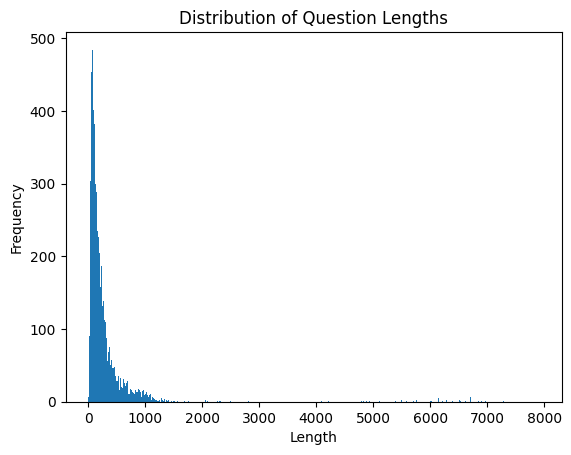

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the column with questions is named 'questions'
# If the column has a different name, replace 'questions' with the actual column name

df['lengths'] = df['questions'].str.len()  # Calculate lengths of questions

plt.hist(df['lengths'], bins=1000)  # Adjust the number of bins as needed
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Question Lengths')
plt.show()

In [9]:
long_questions = df[df['questions'].str.len() > 3000]['questions']

# Print the long questions
print(long_questions)

520.0      1. Налог на прибыль 1. Налог на прибыль - это ...
794.0      В 1990 году, когда в России началась гражданск...
829.0      В 1990 году, когда в России началась гражданск...
838.0      В 1990 году, когда в России началась гражданск...
851.0      В 1990 году, когда я был студентом, я увидел в...
                                 ...                        
6223.0     1) body weight (kg), 2) body height (m), 3) bo...
7938.0     В данном случае, если мы хотим получить вероят...
9855.0     При каких условиях чистый электрический поток ...
9889.0     Натриевая уличная лампа, видна через нейлонову...
10237.0    list1 contains the names of books found in lis...
Name: questions, Length: 89, dtype: object


In [10]:
long_questions.to_csv('long.csv')